# **I. Introduction**

The dataset shows the usage of telecommunication services in Q3 of a particular year. There are several columns provided in the dataset:
- **Customer ID** (A unique customer identifier)
- **Tenure Months** (How long the customer has been with the company by the end of the quarter specified above)
- **Location** (Customer's residence - City)
- **Device Class** (Device classification)
- **Games Product** (Whether the customer uses the internet service for games product)
- **Music Product** (Whether the customer uses the internet service for music product)
- **Education Product** (Whether the customer uses the internet service for education product)
- **Call Center** (Whether the customer uses the call center service)
- **Video Product** (Whether the customer uses video product service)
- **Use MyApp** (Whether the customer uses MyApp service)
- **Payment Method** (The method used for paying the bill)
- **Monthly Purchase** (Total customer’s monthly spent for all services with the unit of thousands of IDR)
- **Churn Label** (Whether the customer left the company in this quarter)
- **Longitude** (Customer’s residence - Longitude)
- **Latitude** (Customer’s residence - Latitude)
- **CLTV** (Customer Lifetime Value with the unit of thousands of IDR - Calculated using company's formulas)

# **II. Project Setup**

In [ ]:
!pip install --q catboost
!pip install --q optuna
!pip install --q shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 5.4 MB/s eta 0:00:00


In [ ]:
# Basic packages
import pandas as pd
import numpy as np
import datetime
import json

# Viz
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter, DayLocator

# Time series
from statsmodels.tsa.stattools import adfuller, acf, pacf, arma_order_select_ic
from sklearn.model_selection import TimeSeriesSplit
import scipy.stats as scs

# Metrics
from sklearn.metrics import roc_auc_score as ras
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Modeling
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import lightgbm as lgbm
import catboost as cb
from sklearn.cluster import KMeans
import optuna
import shap
from sklearn.model_selection import train_test_split

# Settings
import gdown
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
np.random.seed(42)

In [ ]:
data_url = 'https://drive.google.com/uc?id=1lis1DfAdjjNvqBrWI4WKPoIe6Q1k1dFd'
data_file = '/content/Telco_customer_churn_adapted_v2.xlsx'
gdown.download(data_url, data_file, quiet=True)

data = pd.read_excel(data_file)
data.head()

,Customer ID,Tenure Months,Location,Device Class,Games Product,Music Product,Education Product,Call Center,Video Product,Use MyApp,Payment Method,Monthly Purchase (Thou. IDR),Churn Label,Longitude,Latitude,CLTV (Predicted Thou. IDR)
0,0,2,Jakarta,Mid End,Yes,Yes,No,No,No,No,Digital Wallet,70.005,Yes,106.816666,-6.2,4210.7
1,1,2,Jakarta,High End,No,No,No,No,No,No,Pulsa,91.910,Yes,106.816666,-6.2,3511.3
2,2,8,Jakarta,High End,No,No,Yes,No,Yes,Yes,Pulsa,129.545,Yes,106.816666,-6.2,6983.6
3,3,28,Jakarta,High End,No,No,Yes,Yes,Yes,Yes,Pulsa,136.240,Yes,106.816666,-6.2,6503.9
4,4,49,Jakarta,High End,No,Yes,Yes,No,Yes,Yes,Debit,134.810,Yes,106.816666,-6.2,6942.0


# **III. Data Inspection**

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Customer ID                   7043 non-null   int64  
 1   Tenure Months                 7043 non-null   int64  
 2   Location                      7043 non-null   object 
 3   Device Class                  7043 non-null   object 
 4   Games Product                 7043 non-null   object 
 5   Music Product                 7043 non-null   object 
 6   Education Product             7043 non-null   object 
 7   Call Center                   7043 non-null   object 
 8   Video Product                 7043 non-null   object 
 9   Use MyApp                     7043 non-null   object 
 10  Payment Method                7043 non-null   object 
 11  Monthly Purchase (Thou. IDR)  7043 non-null   float64
 12  Churn Label                   7043 non-null   object 
 13  Lon

In [ ]:
print(f'Data shape: {data.shape}')

Data shape: (7043, 16)


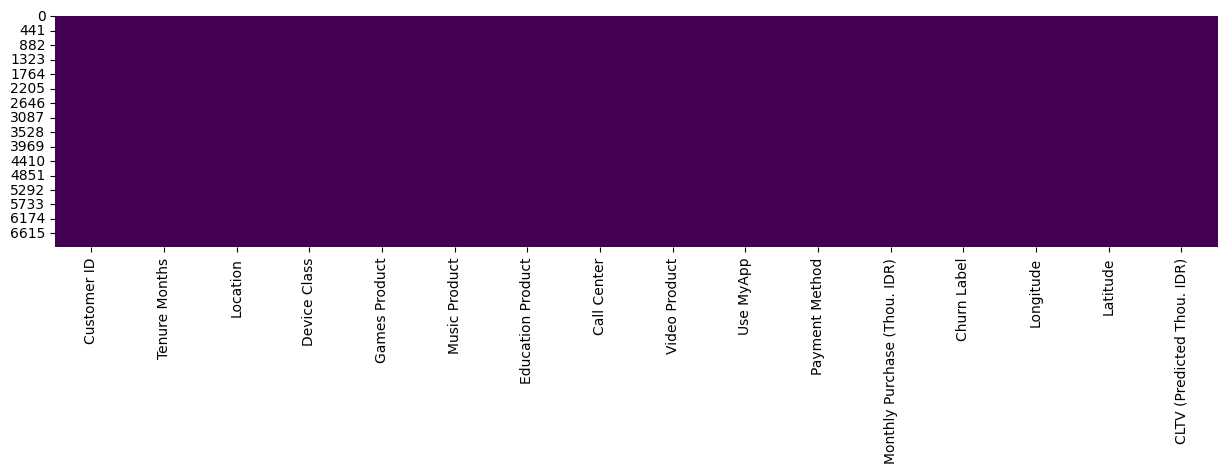

In [ ]:
# Heatmap of missing values
plt.figure(figsize=(15, 3))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')

plt.show()

**Note: No Missing Data**

In [ ]:
print("Data duplicates:", data.duplicated().sum())

Data duplicates: 0


In [ ]:
# Check inconsistencies
for col in data.columns:
    print(col + ":", data[col].unique())
    print()

Customer ID: [   0    1    2 ... 7040 7041 7042]

Tenure Months: [ 2  8 28 49 10  1 47 17  5 34 11 15 18  9  7 12 25 68 55 37  3 27 20  4
 58 53 13  6 19 59 16 52 24 32 38 54 43 63 21 69 22 61 60 48 40 23 39 35
 56 65 33 30 45 46 62 70 50 44 71 26 14 41 66 64 29 42 67 51 31 57 36 72
  0]

Location: ['Jakarta' 'Bandung']

Device Class: ['Mid End' 'High End' 'Low End']

Games Product: ['Yes' 'No' 'No internet service']

Music Product: ['Yes' 'No' 'No internet service']

Education Product: ['No' 'Yes' 'No internet service']

Call Center: ['No' 'Yes']

Video Product: ['No' 'Yes' 'No internet service']

Use MyApp: ['No' 'Yes' 'No internet service']

Payment Method: ['Digital Wallet' 'Pulsa' 'Debit' 'Credit']

Monthly Purchase (Thou. IDR): [ 70.005  91.91  129.545 ... 140.855  82.03  102.31 ]

Churn Label: ['Yes' 'No']

Longitude: [106.816666 107.60981 ]

Latitude: [-6.2      -6.914744]

CLTV (Predicted Thou. IDR): [4210.7 3511.3 6983.6 ... 3601.  6038.5 7218.9]



**Longitude, Latitude:**
- Jakarta = (106.816666, -6.2)
- Bandung = (107.60981, -6.914744)

# **IV. Tableau EDA**
Lansung aja pake **raw data**

<hr><hr>

# **V. Data Preprocessing**

In [ ]:
# Set index to Customer ID
data.set_index("Customer ID", inplace=True)
data.head()

,Tenure Months,Location,Device Class,Games Product,Music Product,Education Product,Call Center,Video Product,Use MyApp,Payment Method,Monthly Purchase (Thou. IDR),Churn Label,Longitude,Latitude,CLTV (Predicted Thou. IDR)
Customer ID,,,,,,,,,,,,,,,
0,2,Jakarta,Mid End,Yes,Yes,No,No,No,No,Digital Wallet,70.005,Yes,106.816666,-6.2,4210.7
1,2,Jakarta,High End,No,No,No,No,No,No,Pulsa,91.910,Yes,106.816666,-6.2,3511.3
2,8,Jakarta,High End,No,No,Yes,No,Yes,Yes,Pulsa,129.545,Yes,106.816666,-6.2,6983.6
3,28,Jakarta,High End,No,No,Yes,Yes,Yes,Yes,Pulsa,136.240,Yes,106.816666,-6.2,6503.9
4,49,Jakarta,High End,No,Yes,Yes,No,Yes,Yes,Debit,134.810,Yes,106.816666,-6.2,6942.0


# **VI. Feature Engineering**

### **1. Encoding**

In [ ]:
export = data.drop("Churn Label",axis=1)
export.to_csv("dataframe.csv")

In [ ]:
# Replacing values to numeric
replace_map = {
    'Yes': 1,
    'No': 0,
    'No internet service': 0
}

for col in ["Games Product", "Music Product", "Education Product", "Call Center", "Video Product", "Use MyApp", "Churn Label"]:
    data[col] = data[col].replace(replace_map)

# Dtypes changed too
data.head()

,Tenure Months,Location,Device Class,Games Product,Music Product,Education Product,Call Center,Video Product,Use MyApp,Payment Method,Monthly Purchase (Thou. IDR),Churn Label,Longitude,Latitude,CLTV (Predicted Thou. IDR)
Customer ID,,,,,,,,,,,,,,,
0,2,Jakarta,Mid End,1,1,0,0,0,0,Digital Wallet,70.005,1,106.816666,-6.2,4210.7
1,2,Jakarta,High End,0,0,0,0,0,0,Pulsa,91.910,1,106.816666,-6.2,3511.3
2,8,Jakarta,High End,0,0,1,0,1,1,Pulsa,129.545,1,106.816666,-6.2,6983.6
3,28,Jakarta,High End,0,0,1,1,1,1,Pulsa,136.240,1,106.816666,-6.2,6503.9
4,49,Jakarta,High End,0,1,1,0,1,1,Debit,134.810,1,106.816666,-6.2,6942.0


In [ ]:
# Ordinal encoding
device_class_map = {
    'High End': 2,
    'Mid End': 1,
    'Low End': 0
}
data['Device Class'] = data['Device Class'].replace(device_class_map)

# One-Hot Encoding
data = pd.get_dummies(data, columns=["Location", "Payment Method"])
data.head()

,Tenure Months,Device Class,Games Product,Music Product,Education Product,Call Center,Video Product,Use MyApp,Monthly Purchase (Thou. IDR),Churn Label,Longitude,Latitude,CLTV (Predicted Thou. IDR),Location_Bandung,Location_Jakarta,Payment Method_Credit,Payment Method_Debit,Payment Method_Digital Wallet,Payment Method_Pulsa
Customer ID,,,,,,,,,,,,,,,,,,,
0,2,1,1,1,0,0,0,0,70.005,1,106.816666,-6.2,4210.7,0,1,0,0,1,0
1,2,2,0,0,0,0,0,0,91.910,1,106.816666,-6.2,3511.3,0,1,0,0,0,1
2,8,2,0,0,1,0,1,1,129.545,1,106.816666,-6.2,6983.6,0,1,0,0,0,1
3,28,2,0,0,1,1,1,1,136.240,1,106.816666,-6.2,6503.9,0,1,0,0,0,1
4,49,2,0,1,1,0,1,1,134.810,1,106.816666,-6.2,6942.0,0,1,0,1,0,0


### **2. New Features**

In [ ]:
data['number_of_products'] = data[ ["Games Product", "Music Product", "Education Product", "Call Center", "Video Product", "Use MyApp"]].sum(axis=1)

In [ ]:
data.head()

,Tenure Months,Device Class,Games Product,Music Product,Education Product,Call Center,Video Product,Use MyApp,Monthly Purchase (Thou. IDR),Churn Label,Longitude,Latitude,CLTV (Predicted Thou. IDR),Location_Bandung,Location_Jakarta,Payment Method_Credit,Payment Method_Debit,Payment Method_Digital Wallet,Payment Method_Pulsa,number_of_products,cost_per_product
Customer ID,,,,,,,,,,,,,,,,,,,,,
0,2,1,1,1,0,0,0,0,70.005,1,106.816666,-6.2,4210.7,0,1,0,0,1,0,2,23.33500
1,2,2,0,0,0,0,0,0,91.910,1,106.816666,-6.2,3511.3,0,1,0,0,0,1,0,91.91000
2,8,2,0,0,1,0,1,1,129.545,1,106.816666,-6.2,6983.6,0,1,0,0,0,1,3,32.38625
3,28,2,0,0,1,1,1,1,136.240,1,106.816666,-6.2,6503.9,0,1,0,0,0,1,4,27.24800
4,49,2,0,1,1,0,1,1,134.810,1,106.816666,-6.2,6942.0,0,1,0,1,0,0,4,26.96200


### **3. Normalization (?)**

## 4. Splitting Dataset (75 : 25)

In [ ]:
num_cols = ["Monthly Purchase (Thou. IDR)", 'CLTV (Predicted Thou. IDR)', 'cost_per_product']

In [ ]:
X = data.copy()
y = X.pop("Churn Label")

In [ ]:
X.drop("number_of_products",axis=1,inplace=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y ,
                                   random_state=104,
                                   test_size=0.20,
                                   shuffle=True)

In [ ]:
X_train.columns

# **VII. Modeling**

### 1. KFold (Validation)

In [ ]:
models = {
    "lr": LogisticRegression(random_state=42, solver='newton-cg'), # Error
    "dtc": DecisionTreeClassifier(random_state=42),
    "rfc": RandomForestClassifier(random_state=42),
    "knn": KNeighborsClassifier(),
    "gnb": GaussianNB(),
    "svc": SVC(random_state=42),
    'xgboost': xgb.XGBClassifier(random_state=42), # Error
    # 'lightgbm': lgbm.LGBMClassifier(random_state=42), # Error
    'catboost': cb.CatBoostClassifier(verbose=0, random_state=42),
    # 'nn': MLPClassifier(random_state=42, hidden_layer_sizes=(10, 10), max_iter=500)
}

In [ ]:
# Function for performing k-fold cross-validation
def kfold_cv(model, X, y):
    # Define KFold cross-validation with 5 splits, random state of 42, and shuffling of data
    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    scores = []  # List to store the evaluation scores

    # Iterate over the train and validation splits
    for train_idx, test_idx in kf.split(X, y):
        # Split the data into training and validation sets based on the indices
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        # Fit the model on the training data
        model.fit(X_train, y_train)

        # Make predictions on the validation data
        predictions = model.predict(X_val)

        # Calculate the evaluation score (here, using RAS macro-average)
        ras_score = accuracy_score(y_val, predictions)

        # Append the score to the list of scores
        scores.append(ras_score)
    return np.mean(scores) # Return the mean of the scores as the overall evaluation score

In [ ]:
# Iterate over the models dictionary
for name, model in models.items():
    # Perform k-fold cross-validation and obtain the evaluation score
    score = kfold_cv(model, X_train, y_train)
    # Print the model name and its corresponding score
    print(f"{name}: {score}")

lr: 0.7919779480252986


KeyboardInterrupt: ignored

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
lr = LogisticRegression(solver='newton-cg')
cb_cl = cb.CatBoostClassifier(verbose=0)

#Setting the range for class weights
weights = np.linspace(0.0,0.99,200)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch_precision = GridSearchCV(estimator= lr,
                          param_grid= param_grid,
                          cv=StratifiedKFold(),
                          n_jobs=-1,
                          scoring='precision',
                          verbose=2).fit(X_train, y_train)

gridsearch_recall = GridSearchCV(estimator= lr,
                          param_grid= param_grid,
                          cv=StratifiedKFold(),
                          n_jobs=-1,
                          scoring='f1',
                          verbose=2).fit(X_train, y_train)

#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch_precision.cv_results_['mean_test_score'], 'weight': (1- weights)})
weigh_data1 = pd.DataFrame({ 'score': gridsearch_recall.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(x=weigh_data['weight'], y=weigh_data['score'])
sns.lineplot(x=weigh_data1['weight'], y=weigh_data1['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)

,score,weight
0,0.264466,1.000000
1,0.266476,0.995025
2,0.276515,0.990050
3,0.282772,0.985075
4,0.288761,0.980101
...,...,...
195,0.000000,0.029899
196,0.000000,0.024925
197,0.000000,0.019950
198,0.000000,0.014975


In [ ]:
1-0.228894

0.7711060000000001

In [ ]:
catboost_param =   {'iterations': 513, 'learning_rate': 0.02667564654663807, 'random_strength': 1, 'bagging_temperature': 1.1762981067497575, 'max_bin': 21, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 11, 'max_depth': 3, 'l2_leaf_reg': 4.709401984486615, 'one_hot_max_size': 4, 'auto_class_weights': None}

In [ ]:
catboost_param = {'iterations': 248, 'learning_rate': 0.03690782449116514, 'random_strength': 5, 'bagging_temperature': 6.055059023394158, 'max_bin': 87, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 6, 'max_depth': 4, 'l2_leaf_reg': 93.20888317568532, 'one_hot_max_size': 9}

In [ ]:
model = LogisticRegression(random_state=42, solver='newton-cg', class_weight={0: 0.45, 1: 0.55})
score = kfold_cv(model, X_train, y_train)
print(score)

0.7969478377496647


In [ ]:
X_train.columns

Index(['Tenure Months', 'Device Class', 'Games Product', 'Music Product',
       'Education Product', 'Call Center', 'Video Product', 'Use MyApp',
       'Monthly Purchase (Thou. IDR)', 'Longitude', 'Latitude',
       'CLTV (Predicted Thou. IDR)', 'Location_Bandung', 'Location_Jakarta',
       'Payment Method_Credit', 'Payment Method_Debit',
       'Payment Method_Digital Wallet', 'Payment Method_Pulsa'],
      dtype='object')

In [ ]:
model = cb.CatBoostClassifier(verbose=0, random_state=42,**catboost_param, class_weights={0: 0.45, 1: 0.55})
score = kfold_cv(model, X_train, y_train)
model.fit(X_train, y_train)
print(score)

0.7980119810685877


In [ ]:
model = cb.CatBoostClassifier(verbose=0, random_state=42)
score = kfold_cv(model, X_train, y_train)
model.fit(X_train, y_train)
print(score)

0.7841688192768805


<Axes: xlabel='Importance', ylabel='Feature'>

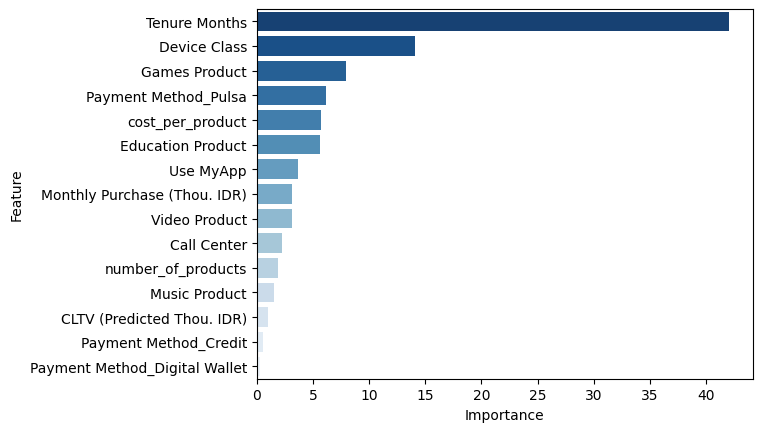

In [ ]:
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_}).sort_values('Importance',ascending=False)

# fig, ax = plt.subplots(2, 1, figsize=(10, 8))

sequential_colors = sns.color_palette("Blues", 15)
reversed_colors = list(reversed(sequential_colors))
sns.barplot(data=feature_importance.head(15),x='Importance',y='Feature',palette=reversed_colors)

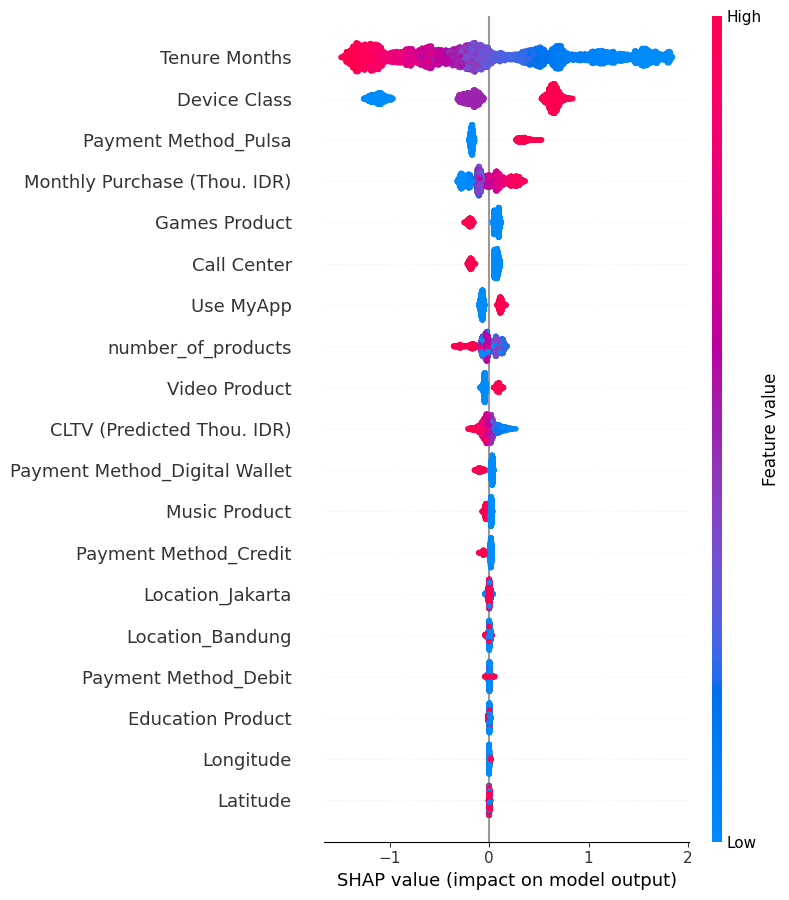

In [ ]:
# SHAP values
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_train.to_numpy())
shap.summary_plot(shap_values, X_train.to_numpy(), feature_names=X_train.columns)

### 2. Testing



In [ ]:
X_test.columns

Index(['Tenure Months', 'Device Class', 'Games Product', 'Music Product',
       'Education Product', 'Call Center', 'Video Product', 'Use MyApp',
       'Monthly Purchase (Thou. IDR)', 'Longitude', 'Latitude',
       'CLTV (Predicted Thou. IDR)', 'Location_Bandung', 'Location_Jakarta',
       'Payment Method_Credit', 'Payment Method_Debit',
       'Payment Method_Digital Wallet', 'Payment Method_Pulsa',
       'number_of_products'],
      dtype='object')

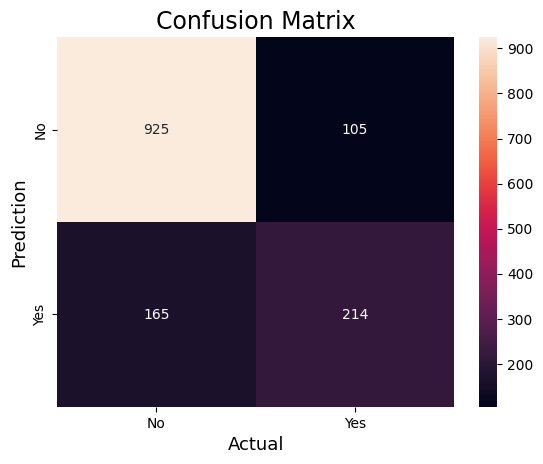

In [ ]:
# preduction
y_pred = model.predict(X_test)

# compute the confusion matrix
cm = confusion_matrix(y_test,y_pred)

#Plot the confusion matrix.
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['No', 'Yes'],
            yticklabels=['No', 'Yes'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)

# Finding precision and recall
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy   :", accuracy)
precision = precision_score(y_test, y_pred)
print("Precision :", precision)
recall = recall_score(y_test, y_pred)
print("Recall    :", recall)
F1_score = f1_score(y_test, y_pred)
print("F1-score  :", F1_score)

Accuracy   : 0.808374733853797
Precision : 0.670846394984326
Recall    : 0.5646437994722955
F1-score  : 0.6131805157593123


In [ ]:
compare_results = pd.DataFrame()
compare_results['Actual'] = y_test
compare_results['Predicted'] = y_pred
compare_results['Churn_Probabilities']= y_prob[:, 1]
compare_results

,Actual,Predicted,Churn_Probabilities
Customer ID,,,
1417,1,1,0.679757
4718,0,0,0.466361
2848,0,0,0.232181
1230,1,0,0.337611
6177,0,0,0.179008
...,...,...,...
2517,0,0,0.181852
5484,0,0,0.084468
956,1,0,0.315652


**Ide (Unsupervised Learning):**
- Clustering KMeans

In [ ]:
def tune_kfold_cv(model, X, y):
    # n_splits makin besar -> SKOR MAKIN BAGUS (awas overfit)
    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    scores = []
    for train_idx, test_idx in kf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        predictions = model.predict(X_val)

        mae_score = f1_score(y_val, predictions)
        print(f'F1-Score: {mae_score:.3f}')
        scores.append(mae_score)
    return scores

In [ ]:
def objective(trial, data=X_train, target=y_train):
    # Define the hyperparameter search space using trial suggestions
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'random_strength': trial.suggest_int('random_strength', 1, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 1, 10),
        'max_bin': trial.suggest_int('max_bin', 4, 255),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 20),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 100),
        'one_hot_max_size': trial.suggest_int('one_hot_max_size', 0, 20),
        # 'auto_class_weights': trial.suggest_categorical('auto_class_weights', [None, 'Balanced'])
        }


    model = cb.CatBoostClassifier(**params,verbose=0, class_weights={0: 0.45, 1: 0.55})

    scores = tune_kfold_cv(model, X_train, y_train)
    return np.sum(scores) / 5

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))
print('Best trial for time spend:', study.best_trial.params)

[I 2023-11-07 02:27:47,770] A new study created in memory with name: no-name-bc02e687-692a-448a-ab3f-3121de006033


F1-Score: 0.566
F1-Score: 0.552
F1-Score: 0.539
F1-Score: 0.531


[I 2023-11-07 02:27:56,088] Trial 0 finished with value: 0.5500879459683622 and parameters: {'iterations': 853, 'learning_rate': 0.14624606111207294, 'random_strength': 4, 'bagging_temperature': 1.111089262317729, 'max_bin': 27, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 16, 'max_depth': 4, 'l2_leaf_reg': 97.4797868465586, 'one_hot_max_size': 14}. Best is trial 0 with value: 0.5500879459683622.


F1-Score: 0.563
F1-Score: 0.539
F1-Score: 0.532
F1-Score: 0.541
F1-Score: 0.519


[I 2023-11-07 02:28:08,547] Trial 1 finished with value: 0.5341563308146322 and parameters: {'iterations': 808, 'learning_rate': 0.23953637884063067, 'random_strength': 7, 'bagging_temperature': 1.4923618555786438, 'max_bin': 193, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 6, 'max_depth': 6, 'l2_leaf_reg': 21.660703275941184, 'one_hot_max_size': 9}. Best is trial 0 with value: 0.5500879459683622.


F1-Score: 0.540
F1-Score: 0.577
F1-Score: 0.594
F1-Score: 0.583
F1-Score: 0.565


[I 2023-11-07 02:28:14,655] Trial 2 finished with value: 0.5758545109405302 and parameters: {'iterations': 508, 'learning_rate': 0.12188399979819411, 'random_strength': 4, 'bagging_temperature': 8.703419011190787, 'max_bin': 202, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 16, 'max_depth': 3, 'l2_leaf_reg': 53.78313155911524, 'one_hot_max_size': 12}. Best is trial 2 with value: 0.5758545109405302.


F1-Score: 0.560
F1-Score: 0.557
F1-Score: 0.548
F1-Score: 0.556
F1-Score: 0.504


[I 2023-11-07 02:28:26,202] Trial 3 finished with value: 0.5417006073597139 and parameters: {'iterations': 588, 'learning_rate': 0.14481757761753078, 'random_strength': 8, 'bagging_temperature': 5.900348156958333, 'max_bin': 12, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 4, 'max_depth': 5, 'l2_leaf_reg': 80.87272436297124, 'one_hot_max_size': 11}. Best is trial 2 with value: 0.5758545109405302.


F1-Score: 0.543
F1-Score: 0.536
F1-Score: 0.536
F1-Score: 0.530
F1-Score: 0.536


[I 2023-11-07 02:29:08,304] Trial 4 finished with value: 0.5332128852880478 and parameters: {'iterations': 909, 'learning_rate': 0.10949346356326402, 'random_strength': 1, 'bagging_temperature': 9.234704633371067, 'max_bin': 194, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 19, 'max_depth': 10, 'l2_leaf_reg': 15.815640755632426, 'one_hot_max_size': 14}. Best is trial 2 with value: 0.5758545109405302.


F1-Score: 0.529
F1-Score: 0.526
F1-Score: 0.556
F1-Score: 0.532
F1-Score: 0.558


[I 2023-11-07 02:29:14,802] Trial 5 finished with value: 0.5477665044704039 and parameters: {'iterations': 283, 'learning_rate': 0.177284814754316, 'random_strength': 6, 'bagging_temperature': 3.2170864463130364, 'max_bin': 117, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 12, 'max_depth': 5, 'l2_leaf_reg': 18.24436601425294, 'one_hot_max_size': 9}. Best is trial 2 with value: 0.5758545109405302.


F1-Score: 0.568
F1-Score: 0.554
F1-Score: 0.548
F1-Score: 0.540
F1-Score: 0.571


[I 2023-11-07 02:29:29,336] Trial 6 finished with value: 0.5518572041770653 and parameters: {'iterations': 700, 'learning_rate': 0.21914985965759362, 'random_strength': 6, 'bagging_temperature': 1.7440188064708337, 'max_bin': 173, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 4, 'l2_leaf_reg': 47.9425892125959, 'one_hot_max_size': 17}. Best is trial 2 with value: 0.5758545109405302.


F1-Score: 0.545
F1-Score: 0.566
F1-Score: 0.554
F1-Score: 0.576
F1-Score: 0.550


[I 2023-11-07 02:29:35,561] Trial 7 finished with value: 0.5616652962076838 and parameters: {'iterations': 183, 'learning_rate': 0.08958927598685434, 'random_strength': 3, 'bagging_temperature': 6.388736051318518, 'max_bin': 50, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 9, 'max_depth': 8, 'l2_leaf_reg': 87.71689799729153, 'one_hot_max_size': 19}. Best is trial 2 with value: 0.5758545109405302.


F1-Score: 0.562
F1-Score: 0.560
F1-Score: 0.559
F1-Score: 0.530
F1-Score: 0.526


[I 2023-11-07 02:29:49,459] Trial 8 finished with value: 0.5422327137870121 and parameters: {'iterations': 519, 'learning_rate': 0.14824260739663175, 'random_strength': 2, 'bagging_temperature': 1.629274355295426, 'max_bin': 37, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 5, 'l2_leaf_reg': 86.51617817997337, 'one_hot_max_size': 15}. Best is trial 2 with value: 0.5758545109405302.


F1-Score: 0.536
F1-Score: 0.507
F1-Score: 0.515
F1-Score: 0.509
F1-Score: 0.488


[I 2023-11-07 02:30:03,328] Trial 9 finished with value: 0.5112927962212025 and parameters: {'iterations': 898, 'learning_rate': 0.24278333174165848, 'random_strength': 1, 'bagging_temperature': 9.352977947927164, 'max_bin': 70, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 20, 'max_depth': 4, 'l2_leaf_reg': 1.4952923507563225, 'one_hot_max_size': 15}. Best is trial 2 with value: 0.5758545109405302.


F1-Score: 0.537
F1-Score: 0.580
F1-Score: 0.597
F1-Score: 0.593
F1-Score: 0.566


[I 2023-11-07 02:30:07,343] Trial 10 finished with value: 0.5842608184990848 and parameters: {'iterations': 396, 'learning_rate': 0.05670119950012055, 'random_strength': 10, 'bagging_temperature': 7.674091073526723, 'max_bin': 252, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 14, 'max_depth': 3, 'l2_leaf_reg': 61.55599882631988, 'one_hot_max_size': 1}. Best is trial 10 with value: 0.5842608184990848.


F1-Score: 0.586
F1-Score: 0.578
F1-Score: 0.622
F1-Score: 0.574
F1-Score: 0.570


[I 2023-11-07 02:30:11,483] Trial 11 finished with value: 0.586537315849426 and parameters: {'iterations': 412, 'learning_rate': 0.02426969874883364, 'random_strength': 10, 'bagging_temperature': 7.699857073066735, 'max_bin': 249, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 14, 'max_depth': 3, 'l2_leaf_reg': 59.53535149881826, 'one_hot_max_size': 1}. Best is trial 11 with value: 0.586537315849426.


F1-Score: 0.588
F1-Score: 0.558
F1-Score: 0.616
F1-Score: 0.584
F1-Score: 0.581


[I 2023-11-07 02:30:16,505] Trial 12 finished with value: 0.5816564892217988 and parameters: {'iterations': 389, 'learning_rate': 0.01628803024470555, 'random_strength': 10, 'bagging_temperature': 7.506681114639813, 'max_bin': 255, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 12, 'max_depth': 3, 'l2_leaf_reg': 65.18359314645251, 'one_hot_max_size': 0}. Best is trial 11 with value: 0.586537315849426.


F1-Score: 0.568
F1-Score: 0.566
F1-Score: 0.628
F1-Score: 0.577
F1-Score: 0.567


[I 2023-11-07 02:30:23,875] Trial 13 finished with value: 0.5843744615271061 and parameters: {'iterations': 367, 'learning_rate': 0.01542364026857708, 'random_strength': 10, 'bagging_temperature': 7.412803140771919, 'max_bin': 252, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 15, 'max_depth': 8, 'l2_leaf_reg': 66.98731898281794, 'one_hot_max_size': 0}. Best is trial 11 with value: 0.586537315849426.


F1-Score: 0.584
F1-Score: 0.522
F1-Score: 0.588
F1-Score: 0.554
F1-Score: 0.539


[I 2023-11-07 02:30:27,087] Trial 14 finished with value: 0.5570376760730887 and parameters: {'iterations': 110, 'learning_rate': 0.014933335383432101, 'random_strength': 9, 'bagging_temperature': 4.679888128070974, 'max_bin': 233, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 9, 'max_depth': 8, 'l2_leaf_reg': 41.61895659563133, 'one_hot_max_size': 4}. Best is trial 11 with value: 0.586537315849426.


F1-Score: 0.582
F1-Score: 0.562
F1-Score: 0.579
F1-Score: 0.579
F1-Score: 0.569


[I 2023-11-07 02:30:33,453] Trial 15 finished with value: 0.5703060603873769 and parameters: {'iterations': 338, 'learning_rate': 0.058612242474866356, 'random_strength': 8, 'bagging_temperature': 7.474594255129638, 'max_bin': 149, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 17, 'max_depth': 8, 'l2_leaf_reg': 69.91658273050145, 'one_hot_max_size': 5}. Best is trial 11 with value: 0.586537315849426.


F1-Score: 0.562
F1-Score: 0.573
F1-Score: 0.577
F1-Score: 0.576
F1-Score: 0.564


[I 2023-11-07 02:30:41,423] Trial 16 finished with value: 0.5745383857092954 and parameters: {'iterations': 232, 'learning_rate': 0.05359790167529868, 'random_strength': 9, 'bagging_temperature': 9.733448725948536, 'max_bin': 104, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 14, 'max_depth': 10, 'l2_leaf_reg': 72.48504284719795, 'one_hot_max_size': 4}. Best is trial 11 with value: 0.586537315849426.


F1-Score: 0.582
F1-Score: 0.514
F1-Score: 0.533
F1-Score: 0.552
F1-Score: 0.541


[I 2023-11-07 02:30:53,502] Trial 17 finished with value: 0.5369016881893768 and parameters: {'iterations': 616, 'learning_rate': 0.28887303149982624, 'random_strength': 10, 'bagging_temperature': 5.133126482906949, 'max_bin': 222, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 1, 'max_depth': 7, 'l2_leaf_reg': 39.400127744579336, 'one_hot_max_size': 2}. Best is trial 11 with value: 0.586537315849426.


F1-Score: 0.544
F1-Score: 0.565
F1-Score: 0.625
F1-Score: 0.581
F1-Score: 0.562


[I 2023-11-07 02:31:03,804] Trial 18 finished with value: 0.5812624115569631 and parameters: {'iterations': 458, 'learning_rate': 0.01764197840922074, 'random_strength': 8, 'bagging_temperature': 8.329391528615965, 'max_bin': 149, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 10, 'max_depth': 9, 'l2_leaf_reg': 53.01036730094235, 'one_hot_max_size': 7}. Best is trial 11 with value: 0.586537315849426.


F1-Score: 0.572
F1-Score: 0.568
F1-Score: 0.568
F1-Score: 0.564
F1-Score: 0.555


[I 2023-11-07 02:31:17,241] Trial 19 finished with value: 0.5660116261123361 and parameters: {'iterations': 700, 'learning_rate': 0.0751556197598656, 'random_strength': 9, 'bagging_temperature': 6.716857311584678, 'max_bin': 223, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 18, 'max_depth': 7, 'l2_leaf_reg': 75.90847696193724, 'one_hot_max_size': 2}. Best is trial 11 with value: 0.586537315849426.


F1-Score: 0.574
F1-Score: 0.577
F1-Score: 0.591
F1-Score: 0.584
F1-Score: 0.555


[I 2023-11-07 02:31:27,946] Trial 20 finished with value: 0.5769039298810851 and parameters: {'iterations': 308, 'learning_rate': 0.04078748887322073, 'random_strength': 7, 'bagging_temperature': 9.948606490963517, 'max_bin': 164, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 14, 'max_depth': 9, 'l2_leaf_reg': 63.90809667977959, 'one_hot_max_size': 7}. Best is trial 11 with value: 0.586537315849426.


F1-Score: 0.577
F1-Score: 0.566
F1-Score: 0.601
F1-Score: 0.596
F1-Score: 0.578


[I 2023-11-07 02:31:32,226] Trial 21 finished with value: 0.5848991424449198 and parameters: {'iterations': 422, 'learning_rate': 0.04496623692899729, 'random_strength': 10, 'bagging_temperature': 7.805594957466845, 'max_bin': 254, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 14, 'max_depth': 3, 'l2_leaf_reg': 60.64349794946827, 'one_hot_max_size': 0}. Best is trial 11 with value: 0.586537315849426.


F1-Score: 0.584
F1-Score: 0.578
F1-Score: 0.603
F1-Score: 0.590
F1-Score: 0.558


[I 2023-11-07 02:31:39,252] Trial 22 finished with value: 0.5795491959378656 and parameters: {'iterations': 420, 'learning_rate': 0.031147531441553633, 'random_strength': 10, 'bagging_temperature': 8.28432850229964, 'max_bin': 238, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 12, 'max_depth': 6, 'l2_leaf_reg': 55.32025666572265, 'one_hot_max_size': 0}. Best is trial 11 with value: 0.586537315849426.


F1-Score: 0.569
F1-Score: 0.569
F1-Score: 0.616
F1-Score: 0.568
F1-Score: 0.584


[I 2023-11-07 02:31:44,814] Trial 23 finished with value: 0.5823523633932901 and parameters: {'iterations': 500, 'learning_rate': 0.01031757381192831, 'random_strength': 9, 'bagging_temperature': 6.741832321201101, 'max_bin': 213, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 15, 'max_depth': 4, 'l2_leaf_reg': 61.06044046219443, 'one_hot_max_size': 3}. Best is trial 11 with value: 0.586537315849426.


F1-Score: 0.575
F1-Score: 0.584
F1-Score: 0.607
F1-Score: 0.594
F1-Score: 0.571


[I 2023-11-07 02:31:49,138] Trial 24 finished with value: 0.5888734308484962 and parameters: {'iterations': 345, 'learning_rate': 0.04011655991955251, 'random_strength': 10, 'bagging_temperature': 7.915220967914433, 'max_bin': 251, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 11, 'max_depth': 3, 'l2_leaf_reg': 69.81655670004822, 'one_hot_max_size': 0}. Best is trial 24 with value: 0.5888734308484962.


F1-Score: 0.589
F1-Score: 0.578
F1-Score: 0.593
F1-Score: 0.580
F1-Score: 0.563


[I 2023-11-07 02:31:59,014] Trial 25 finished with value: 0.5763226908501874 and parameters: {'iterations': 995, 'learning_rate': 0.07760915507378738, 'random_strength': 7, 'bagging_temperature': 8.778311924416883, 'max_bin': 185, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 8, 'max_depth': 3, 'l2_leaf_reg': 78.9657108240267, 'one_hot_max_size': 6}. Best is trial 24 with value: 0.5888734308484962.


F1-Score: 0.568
F1-Score: 0.567
F1-Score: 0.617
F1-Score: 0.592
F1-Score: 0.569


[I 2023-11-07 02:32:02,766] Trial 26 finished with value: 0.5861831878366162 and parameters: {'iterations': 247, 'learning_rate': 0.04839560916309184, 'random_strength': 8, 'bagging_temperature': 8.177610634753021, 'max_bin': 235, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 11, 'max_depth': 3, 'l2_leaf_reg': 72.12377596864215, 'one_hot_max_size': 2}. Best is trial 24 with value: 0.5888734308484962.


F1-Score: 0.585
F1-Score: 0.576
F1-Score: 0.603
F1-Score: 0.588
F1-Score: 0.568


[I 2023-11-07 02:32:05,018] Trial 27 finished with value: 0.5847380463191323 and parameters: {'iterations': 184, 'learning_rate': 0.09364765792161946, 'random_strength': 8, 'bagging_temperature': 8.92200740089046, 'max_bin': 213, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 11, 'max_depth': 4, 'l2_leaf_reg': 71.3623768602945, 'one_hot_max_size': 2}. Best is trial 24 with value: 0.5888734308484962.


F1-Score: 0.587
F1-Score: 0.578
F1-Score: 0.625
F1-Score: 0.592
F1-Score: 0.558


[I 2023-11-07 02:32:08,057] Trial 28 finished with value: 0.5853301020630356 and parameters: {'iterations': 104, 'learning_rate': 0.06912392197457014, 'random_strength': 9, 'bagging_temperature': 8.023405289149142, 'max_bin': 233, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 5, 'l2_leaf_reg': 82.49330698040862, 'one_hot_max_size': 3}. Best is trial 24 with value: 0.5888734308484962.


F1-Score: 0.574
F1-Score: 0.592
F1-Score: 0.617
F1-Score: 0.580
F1-Score: 0.580


[I 2023-11-07 02:32:11,047] Trial 29 finished with value: 0.5914240654558663 and parameters: {'iterations': 277, 'learning_rate': 0.03616295333302266, 'random_strength': 5, 'bagging_temperature': 6.956865268560728, 'max_bin': 237, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 10, 'max_depth': 3, 'l2_leaf_reg': 99.94296515254919, 'one_hot_max_size': 5}. Best is trial 29 with value: 0.5914240654558663.


F1-Score: 0.588
F1-Score: 0.581
F1-Score: 0.621
F1-Score: 0.589
F1-Score: 0.575


[I 2023-11-07 02:32:14,334] Trial 30 finished with value: 0.5877039304248592 and parameters: {'iterations': 193, 'learning_rate': 0.039066468259768714, 'random_strength': 4, 'bagging_temperature': 7.217926858770014, 'max_bin': 78, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 8, 'max_depth': 4, 'l2_leaf_reg': 99.93488492170576, 'one_hot_max_size': 5}. Best is trial 29 with value: 0.5914240654558663.


F1-Score: 0.573
F1-Score: 0.580
F1-Score: 0.612
F1-Score: 0.588
F1-Score: 0.570


[I 2023-11-07 02:32:16,451] Trial 31 finished with value: 0.5851054581892201 and parameters: {'iterations': 182, 'learning_rate': 0.02998688458983361, 'random_strength': 4, 'bagging_temperature': 6.896665019611234, 'max_bin': 68, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 8, 'max_depth': 4, 'l2_leaf_reg': 98.5840631283691, 'one_hot_max_size': 6}. Best is trial 29 with value: 0.5914240654558663.


F1-Score: 0.575
F1-Score: 0.587
F1-Score: 0.619
F1-Score: 0.591
F1-Score: 0.578


[I 2023-11-07 02:32:19,397] Trial 32 finished with value: 0.5913064802111049 and parameters: {'iterations': 266, 'learning_rate': 0.035706496450660596, 'random_strength': 5, 'bagging_temperature': 7.082104142658453, 'max_bin': 95, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'max_depth': 4, 'l2_leaf_reg': 92.53215149787911, 'one_hot_max_size': 8}. Best is trial 29 with value: 0.5914240654558663.


F1-Score: 0.581
F1-Score: 0.584
F1-Score: 0.628
F1-Score: 0.591
F1-Score: 0.564


[I 2023-11-07 02:32:22,310] Trial 33 finished with value: 0.588213987020913 and parameters: {'iterations': 257, 'learning_rate': 0.040574579951345224, 'random_strength': 5, 'bagging_temperature': 6.056839964780789, 'max_bin': 91, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 6, 'max_depth': 4, 'l2_leaf_reg': 92.65586317750325, 'one_hot_max_size': 9}. Best is trial 29 with value: 0.5914240654558663.


F1-Score: 0.573
F1-Score: 0.569
F1-Score: 0.597
F1-Score: 0.585
F1-Score: 0.558


[I 2023-11-07 02:32:26,908] Trial 34 finished with value: 0.5753829690075207 and parameters: {'iterations': 293, 'learning_rate': 0.06319643528657447, 'random_strength': 5, 'bagging_temperature': 5.957427716118771, 'max_bin': 96, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 6, 'max_depth': 5, 'l2_leaf_reg': 94.06716798386041, 'one_hot_max_size': 9}. Best is trial 29 with value: 0.5914240654558663.


F1-Score: 0.567
F1-Score: 0.571
F1-Score: 0.592
F1-Score: 0.572
F1-Score: 0.570


[I 2023-11-07 02:32:30,440] Trial 35 finished with value: 0.5743695722984874 and parameters: {'iterations': 258, 'learning_rate': 0.08889699265935212, 'random_strength': 5, 'bagging_temperature': 6.070399224277183, 'max_bin': 130, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 6, 'max_depth': 6, 'l2_leaf_reg': 92.65873207663918, 'one_hot_max_size': 11}. Best is trial 29 with value: 0.5914240654558663.


F1-Score: 0.566
F1-Score: 0.577
F1-Score: 0.588
F1-Score: 0.569
F1-Score: 0.558


[I 2023-11-07 02:32:34,123] Trial 36 finished with value: 0.5710216004769324 and parameters: {'iterations': 307, 'learning_rate': 0.11318933050228548, 'random_strength': 5, 'bagging_temperature': 5.521111731464622, 'max_bin': 89, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 4, 'max_depth': 5, 'l2_leaf_reg': 92.02513515705402, 'one_hot_max_size': 12}. Best is trial 29 with value: 0.5914240654558663.


F1-Score: 0.564
F1-Score: 0.579
F1-Score: 0.605
F1-Score: 0.594
F1-Score: 0.572


[I 2023-11-07 02:32:40,871] Trial 37 finished with value: 0.5869207603541083 and parameters: {'iterations': 348, 'learning_rate': 0.038127558451839585, 'random_strength': 6, 'bagging_temperature': 6.8544883895183375, 'max_bin': 119, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 2, 'max_depth': 4, 'l2_leaf_reg': 87.47842619070582, 'one_hot_max_size': 8}. Best is trial 29 with value: 0.5914240654558663.


F1-Score: 0.585
F1-Score: 0.573
F1-Score: 0.592
F1-Score: 0.580
F1-Score: 0.551


[I 2023-11-07 02:32:42,324] Trial 38 finished with value: 0.5759935678925927 and parameters: {'iterations': 134, 'learning_rate': 0.1253171398803922, 'random_strength': 3, 'bagging_temperature': 6.230488302301596, 'max_bin': 7, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 5, 'max_depth': 3, 'l2_leaf_reg': 96.08944223014785, 'one_hot_max_size': 12}. Best is trial 29 with value: 0.5914240654558663.


F1-Score: 0.584
F1-Score: 0.572
F1-Score: 0.600
F1-Score: 0.581
F1-Score: 0.558


[I 2023-11-07 02:32:45,612] Trial 39 finished with value: 0.5772918788959059 and parameters: {'iterations': 217, 'learning_rate': 0.06702039705572681, 'random_strength': 3, 'bagging_temperature': 7.113633595840174, 'max_bin': 27, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 4, 'l2_leaf_reg': 81.03852991908418, 'one_hot_max_size': 10}. Best is trial 29 with value: 0.5914240654558663.


F1-Score: 0.576
F1-Score: 0.580
F1-Score: 0.586
F1-Score: 0.582
F1-Score: 0.562


[I 2023-11-07 02:32:57,536] Trial 40 finished with value: 0.5760982124844755 and parameters: {'iterations': 465, 'learning_rate': 0.03445787683728012, 'random_strength': 6, 'bagging_temperature': 6.4193671692801875, 'max_bin': 48, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 5, 'l2_leaf_reg': 90.0814567690333, 'one_hot_max_size': 7}. Best is trial 29 with value: 0.5914240654558663.


F1-Score: 0.570
F1-Score: 0.572
F1-Score: 0.604
F1-Score: 0.586
F1-Score: 0.568


[I 2023-11-07 02:32:59,402] Trial 41 finished with value: 0.5823997540393203 and parameters: {'iterations': 163, 'learning_rate': 0.04370294506967155, 'random_strength': 4, 'bagging_temperature': 7.136547609606834, 'max_bin': 77, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 9, 'max_depth': 4, 'l2_leaf_reg': 98.88741411742511, 'one_hot_max_size': 8}. Best is trial 29 with value: 0.5914240654558663.


F1-Score: 0.582
F1-Score: 0.586
F1-Score: 0.615
F1-Score: 0.579
F1-Score: 0.576


[I 2023-11-07 02:33:02,852] Trial 42 finished with value: 0.585951392457293 and parameters: {'iterations': 212, 'learning_rate': 0.030644597968922997, 'random_strength': 4, 'bagging_temperature': 6.441995301989371, 'max_bin': 84, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 8, 'max_depth': 4, 'l2_leaf_reg': 98.90061763246614, 'one_hot_max_size': 5}. Best is trial 29 with value: 0.5914240654558663.


F1-Score: 0.574
F1-Score: 0.584
F1-Score: 0.609
F1-Score: 0.585
F1-Score: 0.575


[I 2023-11-07 02:33:05,635] Trial 43 finished with value: 0.5886574806094711 and parameters: {'iterations': 270, 'learning_rate': 0.05616608490741078, 'random_strength': 5, 'bagging_temperature': 7.211079206235438, 'max_bin': 110, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'max_depth': 3, 'l2_leaf_reg': 83.52117789610902, 'one_hot_max_size': 10}. Best is trial 29 with value: 0.5914240654558663.


F1-Score: 0.591
F1-Score: 0.576
F1-Score: 0.603
F1-Score: 0.577
F1-Score: 0.576


[I 2023-11-07 02:33:08,467] Trial 44 finished with value: 0.5840359428144201 and parameters: {'iterations': 274, 'learning_rate': 0.054266175785598475, 'random_strength': 5, 'bagging_temperature': 8.389983787416597, 'max_bin': 110, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 4, 'max_depth': 3, 'l2_leaf_reg': 85.01928327908449, 'one_hot_max_size': 10}. Best is trial 29 with value: 0.5914240654558663.


F1-Score: 0.588
F1-Score: 0.568
F1-Score: 0.597
F1-Score: 0.576
F1-Score: 0.581


[I 2023-11-07 02:33:11,775] Trial 45 finished with value: 0.5822291070081034 and parameters: {'iterations': 335, 'learning_rate': 0.08532874060427834, 'random_strength': 6, 'bagging_temperature': 5.606779590589305, 'max_bin': 131, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'max_depth': 3, 'l2_leaf_reg': 89.4273722125489, 'one_hot_max_size': 13}. Best is trial 29 with value: 0.5914240654558663.


F1-Score: 0.589
F1-Score: 0.538
F1-Score: 0.580
F1-Score: 0.560
F1-Score: 0.554


[I 2023-11-07 02:33:15,001] Trial 46 finished with value: 0.560620271291669 and parameters: {'iterations': 152, 'learning_rate': 0.024620704608851747, 'random_strength': 7, 'bagging_temperature': 7.689460639267035, 'max_bin': 60, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 3, 'l2_leaf_reg': 83.47278821403003, 'one_hot_max_size': 9}. Best is trial 29 with value: 0.5914240654558663.


F1-Score: 0.571
F1-Score: 0.575
F1-Score: 0.599
F1-Score: 0.586
F1-Score: 0.572


[I 2023-11-07 02:33:17,588] Trial 47 finished with value: 0.5851788615921494 and parameters: {'iterations': 251, 'learning_rate': 0.062011716042102635, 'random_strength': 5, 'bagging_temperature': 7.28277566247158, 'max_bin': 146, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 5, 'max_depth': 3, 'l2_leaf_reg': 94.17015228949086, 'one_hot_max_size': 11}. Best is trial 29 with value: 0.5914240654558663.


F1-Score: 0.594
F1-Score: 0.575
F1-Score: 0.605
F1-Score: 0.587
F1-Score: 0.569


[I 2023-11-07 02:33:21,096] Trial 48 finished with value: 0.5875623842096342 and parameters: {'iterations': 355, 'learning_rate': 0.05201472624723117, 'random_strength': 2, 'bagging_temperature': 8.011279502966733, 'max_bin': 98, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 12, 'max_depth': 3, 'l2_leaf_reg': 86.81978020858176, 'one_hot_max_size': 8}. Best is trial 29 with value: 0.5914240654558663.


F1-Score: 0.601
F1-Score: 0.583
F1-Score: 0.586
F1-Score: 0.575
F1-Score: 0.557


[I 2023-11-07 02:33:24,723] Trial 49 finished with value: 0.5765636966736981 and parameters: {'iterations': 321, 'learning_rate': 0.09923691840222909, 'random_strength': 5, 'bagging_temperature': 6.5310200305480475, 'max_bin': 114, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 6, 'max_depth': 4, 'l2_leaf_reg': 79.26750851249162, 'one_hot_max_size': 14}. Best is trial 29 with value: 0.5914240654558663.


F1-Score: 0.581
F1-Score: 0.563
F1-Score: 0.620
F1-Score: 0.582
F1-Score: 0.569


[I 2023-11-07 02:33:34,643] Trial 50 finished with value: 0.5826129581228467 and parameters: {'iterations': 377, 'learning_rate': 0.011195462665555, 'random_strength': 4, 'bagging_temperature': 5.787245534927616, 'max_bin': 199, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 3, 'max_depth': 5, 'l2_leaf_reg': 92.30006122652604, 'one_hot_max_size': 17}. Best is trial 29 with value: 0.5914240654558663.


F1-Score: 0.580
F1-Score: 0.563
F1-Score: 0.614
F1-Score: 0.589
F1-Score: 0.568


[I 2023-11-07 02:33:38,351] Trial 51 finished with value: 0.5831240930744186 and parameters: {'iterations': 292, 'learning_rate': 0.03868887672692117, 'random_strength': 4, 'bagging_temperature': 7.288508807499785, 'max_bin': 83, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 9, 'max_depth': 4, 'l2_leaf_reg': 95.79095585079705, 'one_hot_max_size': 6}. Best is trial 29 with value: 0.5914240654558663.


F1-Score: 0.581
F1-Score: 0.583
F1-Score: 0.619
F1-Score: 0.583
F1-Score: 0.560


[I 2023-11-07 02:33:40,967] Trial 52 finished with value: 0.5879971171092606 and parameters: {'iterations': 205, 'learning_rate': 0.0780285379250125, 'random_strength': 6, 'bagging_temperature': 7.009828567265975, 'max_bin': 60, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 8, 'max_depth': 3, 'l2_leaf_reg': 99.83940831382378, 'one_hot_max_size': 5}. Best is trial 29 with value: 0.5914240654558663.


F1-Score: 0.595
F1-Score: 0.576
F1-Score: 0.604
F1-Score: 0.589
F1-Score: 0.574


[I 2023-11-07 02:33:43,235] Trial 53 finished with value: 0.5854838803134144 and parameters: {'iterations': 225, 'learning_rate': 0.07563254944713482, 'random_strength': 6, 'bagging_temperature': 6.911396493005478, 'max_bin': 54, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'max_depth': 3, 'l2_leaf_reg': 89.40752957776594, 'one_hot_max_size': 4}. Best is trial 29 with value: 0.5914240654558663.


F1-Score: 0.585
F1-Score: 0.566
F1-Score: 0.613
F1-Score: 0.577
F1-Score: 0.578


[I 2023-11-07 02:33:45,838] Trial 54 finished with value: 0.5804669635855604 and parameters: {'iterations': 263, 'learning_rate': 0.025660701575456475, 'random_strength': 6, 'bagging_temperature': 7.721273300424832, 'max_bin': 67, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 11, 'max_depth': 3, 'l2_leaf_reg': 84.99155456788247, 'one_hot_max_size': 9}. Best is trial 29 with value: 0.5914240654558663.


F1-Score: 0.568
F1-Score: 0.569
F1-Score: 0.597
F1-Score: 0.585
F1-Score: 0.566


[I 2023-11-07 02:33:54,051] Trial 55 finished with value: 0.5816666751943339 and parameters: {'iterations': 615, 'learning_rate': 0.05305472540146283, 'random_strength': 7, 'bagging_temperature': 6.207539804913008, 'max_bin': 122, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 13, 'max_depth': 3, 'l2_leaf_reg': 95.55450886004535, 'one_hot_max_size': 10}. Best is trial 29 with value: 0.5914240654558663.


F1-Score: 0.591
F1-Score: 0.573
F1-Score: 0.567
F1-Score: 0.558
F1-Score: 0.545


[I 2023-11-07 02:34:06,509] Trial 56 finished with value: 0.56051192798921 and parameters: {'iterations': 793, 'learning_rate': 0.06571483010459181, 'random_strength': 3, 'bagging_temperature': 6.634256190058424, 'max_bin': 41, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 3, 'l2_leaf_reg': 90.24248310863187, 'one_hot_max_size': 7}. Best is trial 29 with value: 0.5914240654558663.


F1-Score: 0.559
F1-Score: 0.537
F1-Score: 0.579
F1-Score: 0.553
F1-Score: 0.541


[I 2023-11-07 02:34:08,069] Trial 57 finished with value: 0.5540293222821593 and parameters: {'iterations': 124, 'learning_rate': 0.01969226272276029, 'random_strength': 5, 'bagging_temperature': 5.2379576315987855, 'max_bin': 140, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 10, 'max_depth': 4, 'l2_leaf_reg': 74.57864610055023, 'one_hot_max_size': 20}. Best is trial 29 with value: 0.5914240654558663.


F1-Score: 0.559
F1-Score: 0.569
F1-Score: 0.605
F1-Score: 0.587
F1-Score: 0.568


[I 2023-11-07 02:34:12,936] Trial 58 finished with value: 0.583881033607182 and parameters: {'iterations': 453, 'learning_rate': 0.04758368851225708, 'random_strength': 6, 'bagging_temperature': 7.453943222932132, 'max_bin': 168, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 6, 'max_depth': 3, 'l2_leaf_reg': 99.99086350253745, 'one_hot_max_size': 11}. Best is trial 29 with value: 0.5914240654558663.


F1-Score: 0.590
F1-Score: 0.576
F1-Score: 0.591
F1-Score: 0.599
F1-Score: 0.570


[I 2023-11-07 02:34:15,735] Trial 59 finished with value: 0.5840499163647991 and parameters: {'iterations': 159, 'learning_rate': 0.08257384469682044, 'random_strength': 2, 'bagging_temperature': 7.855126182031047, 'max_bin': 93, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 5, 'max_depth': 3, 'l2_leaf_reg': 77.12532273235749, 'one_hot_max_size': 1}. Best is trial 29 with value: 0.5914240654558663.


F1-Score: 0.585
F1-Score: 0.578
F1-Score: 0.601
F1-Score: 0.556
F1-Score: 0.550


[I 2023-11-07 02:34:22,029] Trial 60 finished with value: 0.5676444736703065 and parameters: {'iterations': 558, 'learning_rate': 0.07350519057096405, 'random_strength': 5, 'bagging_temperature': 8.446250814665142, 'max_bin': 104, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 13, 'max_depth': 5, 'l2_leaf_reg': 84.0156383116821, 'one_hot_max_size': 3}. Best is trial 29 with value: 0.5914240654558663.


F1-Score: 0.553
F1-Score: 0.585
F1-Score: 0.614
F1-Score: 0.589
F1-Score: 0.579


[I 2023-11-07 02:34:24,192] Trial 61 finished with value: 0.5903350764642461 and parameters: {'iterations': 191, 'learning_rate': 0.03844421536692437, 'random_strength': 4, 'bagging_temperature': 7.109933754737805, 'max_bin': 72, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 8, 'max_depth': 4, 'l2_leaf_reg': 96.72431454885343, 'one_hot_max_size': 5}. Best is trial 29 with value: 0.5914240654558663.


F1-Score: 0.584
F1-Score: 0.588
F1-Score: 0.615
F1-Score: 0.587
F1-Score: 0.568


[I 2023-11-07 02:34:27,739] Trial 62 finished with value: 0.5894734763502033 and parameters: {'iterations': 216, 'learning_rate': 0.05884186571237589, 'random_strength': 4, 'bagging_temperature': 6.9751991551179335, 'max_bin': 105, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 8, 'max_depth': 4, 'l2_leaf_reg': 94.2964257776198, 'one_hot_max_size': 6}. Best is trial 29 with value: 0.5914240654558663.


F1-Score: 0.590
F1-Score: 0.583
F1-Score: 0.619
F1-Score: 0.580
F1-Score: 0.575


[I 2023-11-07 02:34:30,340] Trial 63 finished with value: 0.5882592126526871 and parameters: {'iterations': 235, 'learning_rate': 0.02405838052531991, 'random_strength': 3, 'bagging_temperature': 6.578404008715862, 'max_bin': 111, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 9, 'max_depth': 4, 'l2_leaf_reg': 95.63582252827204, 'one_hot_max_size': 8}. Best is trial 29 with value: 0.5914240654558663.


F1-Score: 0.585
F1-Score: 0.581
F1-Score: 0.612
F1-Score: 0.585
F1-Score: 0.569


[I 2023-11-07 02:34:34,549] Trial 64 finished with value: 0.5843458228569298 and parameters: {'iterations': 287, 'learning_rate': 0.022256079013449035, 'random_strength': 3, 'bagging_temperature': 7.465796947258611, 'max_bin': 245, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 9, 'max_depth': 6, 'l2_leaf_reg': 95.93886537833009, 'one_hot_max_size': 6}. Best is trial 29 with value: 0.5914240654558663.


F1-Score: 0.574
F1-Score: 0.581
F1-Score: 0.605
F1-Score: 0.592
F1-Score: 0.560


[I 2023-11-07 02:34:37,146] Trial 65 finished with value: 0.5835657815664245 and parameters: {'iterations': 232, 'learning_rate': 0.058129401515131476, 'random_strength': 3, 'bagging_temperature': 6.611893896856621, 'max_bin': 107, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 11, 'max_depth': 4, 'l2_leaf_reg': 87.91746052601479, 'one_hot_max_size': 8}. Best is trial 29 with value: 0.5914240654558663.


F1-Score: 0.580
F1-Score: 0.566
F1-Score: 0.613
F1-Score: 0.598
F1-Score: 0.567


[I 2023-11-07 02:34:42,921] Trial 66 finished with value: 0.5843866649014913 and parameters: {'iterations': 179, 'learning_rate': 0.03215196367230174, 'random_strength': 4, 'bagging_temperature': 7.041847614256223, 'max_bin': 126, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 10, 'max_depth': 5, 'l2_leaf_reg': 96.04473478377871, 'one_hot_max_size': 4}. Best is trial 29 with value: 0.5914240654558663.


F1-Score: 0.578
F1-Score: 0.545
F1-Score: 0.602
F1-Score: 0.571
F1-Score: 0.571


[I 2023-11-07 02:34:46,353] Trial 67 finished with value: 0.5726327276239725 and parameters: {'iterations': 320, 'learning_rate': 0.01027132032986841, 'random_strength': 3, 'bagging_temperature': 7.458919127667389, 'max_bin': 100, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 8, 'max_depth': 4, 'l2_leaf_reg': 82.17460337869863, 'one_hot_max_size': 7}. Best is trial 29 with value: 0.5914240654558663.


F1-Score: 0.574
F1-Score: 0.575
F1-Score: 0.600
F1-Score: 0.578
F1-Score: 0.570


[I 2023-11-07 02:34:52,298] Trial 68 finished with value: 0.5817158750573121 and parameters: {'iterations': 400, 'learning_rate': 0.04452893605101301, 'random_strength': 2, 'bagging_temperature': 7.999935137137523, 'max_bin': 180, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'max_depth': 5, 'l2_leaf_reg': 91.448090009679, 'one_hot_max_size': 5}. Best is trial 29 with value: 0.5914240654558663.


F1-Score: 0.586
F1-Score: 0.543
F1-Score: 0.605
F1-Score: 0.552
F1-Score: 0.561


[I 2023-11-07 02:34:54,141] Trial 69 finished with value: 0.5663813084778645 and parameters: {'iterations': 143, 'learning_rate': 0.021936215901780118, 'random_strength': 4, 'bagging_temperature': 6.787520158730181, 'max_bin': 222, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 9, 'max_depth': 4, 'l2_leaf_reg': 86.77813757849555, 'one_hot_max_size': 6}. Best is trial 29 with value: 0.5914240654558663.


F1-Score: 0.571
F1-Score: 0.572
F1-Score: 0.613
F1-Score: 0.582
F1-Score: 0.576


[I 2023-11-07 02:34:55,435] Trial 70 finished with value: 0.5857420492187402 and parameters: {'iterations': 102, 'learning_rate': 0.06031404747240993, 'random_strength': 4, 'bagging_temperature': 6.352185920456144, 'max_bin': 157, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 13, 'max_depth': 4, 'l2_leaf_reg': 78.42150904830602, 'one_hot_max_size': 3}. Best is trial 29 with value: 0.5914240654558663.


F1-Score: 0.585
F1-Score: 0.585
F1-Score: 0.618
F1-Score: 0.596
F1-Score: 0.575


[I 2023-11-07 02:34:58,124] Trial 71 finished with value: 0.5920976826688358 and parameters: {'iterations': 248, 'learning_rate': 0.03690782449116514, 'random_strength': 5, 'bagging_temperature': 6.055059023394158, 'max_bin': 87, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 6, 'max_depth': 4, 'l2_leaf_reg': 93.20888317568532, 'one_hot_max_size': 9}. Best is trial 71 with value: 0.5920976826688358.


F1-Score: 0.587
F1-Score: 0.582
F1-Score: 0.619
F1-Score: 0.595
F1-Score: 0.566


[I 2023-11-07 02:35:00,565] Trial 72 finished with value: 0.5890947438562135 and parameters: {'iterations': 228, 'learning_rate': 0.04888792228685382, 'random_strength': 5, 'bagging_temperature': 6.655336551876483, 'max_bin': 72, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'max_depth': 4, 'l2_leaf_reg': 94.58355524187046, 'one_hot_max_size': 8}. Best is trial 71 with value: 0.5920976826688358.


F1-Score: 0.584
F1-Score: 0.578
F1-Score: 0.612
F1-Score: 0.585
F1-Score: 0.569


[I 2023-11-07 02:35:04,592] Trial 73 finished with value: 0.585112847501062 and parameters: {'iterations': 274, 'learning_rate': 0.04856189985265236, 'random_strength': 5, 'bagging_temperature': 7.142980595780919, 'max_bin': 80, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'max_depth': 4, 'l2_leaf_reg': 91.73989795116606, 'one_hot_max_size': 10}. Best is trial 71 with value: 0.5920976826688358.


F1-Score: 0.582
F1-Score: 0.586
F1-Score: 0.621
F1-Score: 0.580
F1-Score: 0.574


[I 2023-11-07 02:35:06,692] Trial 74 finished with value: 0.5878126937341006 and parameters: {'iterations': 172, 'learning_rate': 0.035239217801486415, 'random_strength': 5, 'bagging_temperature': 7.581388751865501, 'max_bin': 75, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 8, 'max_depth': 5, 'l2_leaf_reg': 93.48378604927314, 'one_hot_max_size': 7}. Best is trial 71 with value: 0.5920976826688358.


F1-Score: 0.578
F1-Score: 0.578
F1-Score: 0.612
F1-Score: 0.590
F1-Score: 0.570


[I 2023-11-07 02:35:08,818] Trial 75 finished with value: 0.5879149005260036 and parameters: {'iterations': 203, 'learning_rate': 0.045659161462468324, 'random_strength': 4, 'bagging_temperature': 6.808711506135031, 'max_bin': 68, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'max_depth': 3, 'l2_leaf_reg': 88.8613645659198, 'one_hot_max_size': 8}. Best is trial 71 with value: 0.5920976826688358.


F1-Score: 0.590
F1-Score: 0.562
F1-Score: 0.586
F1-Score: 0.575
F1-Score: 0.568


[I 2023-11-07 02:35:12,777] Trial 76 finished with value: 0.5704703054495581 and parameters: {'iterations': 313, 'learning_rate': 0.06997836600533057, 'random_strength': 5, 'bagging_temperature': 6.216335705323198, 'max_bin': 84, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 6, 'max_depth': 6, 'l2_leaf_reg': 97.38793235418362, 'one_hot_max_size': 13}. Best is trial 71 with value: 0.5920976826688358.


F1-Score: 0.562
F1-Score: 0.580
F1-Score: 0.602
F1-Score: 0.590
F1-Score: 0.578


[I 2023-11-07 02:35:20,315] Trial 77 finished with value: 0.5881278382711141 and parameters: {'iterations': 372, 'learning_rate': 0.032525026635204304, 'random_strength': 5, 'bagging_temperature': 5.798958576133433, 'max_bin': 244, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 4, 'max_depth': 4, 'l2_leaf_reg': 86.78457241051862, 'one_hot_max_size': 4}. Best is trial 71 with value: 0.5920976826688358.


F1-Score: 0.591
F1-Score: 0.564
F1-Score: 0.607
F1-Score: 0.585
F1-Score: 0.560


[I 2023-11-07 02:35:22,705] Trial 78 finished with value: 0.5834742159535525 and parameters: {'iterations': 243, 'learning_rate': 0.05249589557929071, 'random_strength': 4, 'bagging_temperature': 6.9695235068765164, 'max_bin': 25, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 5, 'max_depth': 3, 'l2_leaf_reg': 81.67147849364359, 'one_hot_max_size': 9}. Best is trial 71 with value: 0.5920976826688358.


F1-Score: 0.601
F1-Score: 0.582
F1-Score: 0.612
F1-Score: 0.598
F1-Score: 0.566


[I 2023-11-07 02:35:27,449] Trial 79 finished with value: 0.5906419382734253 and parameters: {'iterations': 194, 'learning_rate': 0.06016510784324255, 'random_strength': 6, 'bagging_temperature': 7.240241275326147, 'max_bin': 90, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 4, 'l2_leaf_reg': 96.96983889827821, 'one_hot_max_size': 11}. Best is trial 71 with value: 0.5920976826688358.


F1-Score: 0.596
F1-Score: 0.560
F1-Score: 0.598
F1-Score: 0.568
F1-Score: 0.564


[I 2023-11-07 02:35:33,088] Trial 80 finished with value: 0.5732996785038694 and parameters: {'iterations': 196, 'learning_rate': 0.017296676699990465, 'random_strength': 6, 'bagging_temperature': 7.697119973869762, 'max_bin': 73, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 7, 'l2_leaf_reg': 97.30217107244714, 'one_hot_max_size': 13}. Best is trial 71 with value: 0.5920976826688358.


F1-Score: 0.576
F1-Score: 0.579
F1-Score: 0.615
F1-Score: 0.600
F1-Score: 0.561


[I 2023-11-07 02:35:38,377] Trial 81 finished with value: 0.5878778840766092 and parameters: {'iterations': 271, 'learning_rate': 0.061506098777731874, 'random_strength': 5, 'bagging_temperature': 7.258964293322823, 'max_bin': 90, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 4, 'l2_leaf_reg': 93.38784968455745, 'one_hot_max_size': 11}. Best is trial 71 with value: 0.5920976826688358.


F1-Score: 0.585
F1-Score: 0.576
F1-Score: 0.616
F1-Score: 0.591
F1-Score: 0.584


[I 2023-11-07 02:35:43,502] Trial 82 finished with value: 0.5906565605402846 and parameters: {'iterations': 219, 'learning_rate': 0.04192206800952575, 'random_strength': 5, 'bagging_temperature': 6.7551169822362995, 'max_bin': 103, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 4, 'l2_leaf_reg': 89.91850837924372, 'one_hot_max_size': 10}. Best is trial 71 with value: 0.5920976826688358.


F1-Score: 0.586
F1-Score: 0.579
F1-Score: 0.607
F1-Score: 0.601
F1-Score: 0.577


[I 2023-11-07 02:35:48,900] Trial 83 finished with value: 0.5903625594641329 and parameters: {'iterations': 222, 'learning_rate': 0.03930889952747772, 'random_strength': 4, 'bagging_temperature': 6.4182976955679, 'max_bin': 101, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 5, 'l2_leaf_reg': 90.80459195625818, 'one_hot_max_size': 12}. Best is trial 71 with value: 0.5920976826688358.


F1-Score: 0.589
F1-Score: 0.590
F1-Score: 0.608
F1-Score: 0.585
F1-Score: 0.566


[I 2023-11-07 02:35:52,691] Trial 84 finished with value: 0.5873214659972508 and parameters: {'iterations': 128, 'learning_rate': 0.03971276368826038, 'random_strength': 4, 'bagging_temperature': 6.007790690589198, 'max_bin': 100, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 4, 'l2_leaf_reg': 90.01030856024931, 'one_hot_max_size': 10}. Best is trial 71 with value: 0.5920976826688358.


F1-Score: 0.589
F1-Score: 0.566
F1-Score: 0.614
F1-Score: 0.591
F1-Score: 0.556


[I 2023-11-07 02:35:57,936] Trial 85 finished with value: 0.5824740405519084 and parameters: {'iterations': 222, 'learning_rate': 0.027201013445879756, 'random_strength': 6, 'bagging_temperature': 6.346391208948283, 'max_bin': 62, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 5, 'l2_leaf_reg': 97.11726245024553, 'one_hot_max_size': 12}. Best is trial 71 with value: 0.5920976826688358.


F1-Score: 0.585
F1-Score: 0.565
F1-Score: 0.595
F1-Score: 0.581
F1-Score: 0.554


[I 2023-11-07 02:36:01,908] Trial 86 finished with value: 0.5737414330780639 and parameters: {'iterations': 163, 'learning_rate': 0.06775118773631336, 'random_strength': 4, 'bagging_temperature': 6.638397445777404, 'max_bin': 87, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 5, 'l2_leaf_reg': 93.85007101495084, 'one_hot_max_size': 6}. Best is trial 71 with value: 0.5920976826688358.


F1-Score: 0.573
F1-Score: 0.575
F1-Score: 0.620
F1-Score: 0.583
F1-Score: 0.576


[I 2023-11-07 02:36:08,053] Trial 87 finished with value: 0.5866374046274249 and parameters: {'iterations': 194, 'learning_rate': 0.035190642475041216, 'random_strength': 5, 'bagging_temperature': 6.462101983164098, 'max_bin': 135, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 5, 'l2_leaf_reg': 97.75596378229997, 'one_hot_max_size': 15}. Best is trial 71 with value: 0.5920976826688358.


F1-Score: 0.579
F1-Score: 0.572
F1-Score: 0.617
F1-Score: 0.597
F1-Score: 0.573


[I 2023-11-07 02:36:13,757] Trial 88 finished with value: 0.5893760746941465 and parameters: {'iterations': 296, 'learning_rate': 0.028661451046740165, 'random_strength': 5, 'bagging_temperature': 6.773381109548096, 'max_bin': 116, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 4, 'l2_leaf_reg': 91.16604371316404, 'one_hot_max_size': 11}. Best is trial 71 with value: 0.5920976826688358.


F1-Score: 0.587
F1-Score: 0.564
F1-Score: 0.610
F1-Score: 0.584
F1-Score: 0.572


[I 2023-11-07 02:36:19,815] Trial 89 finished with value: 0.581720988280283 and parameters: {'iterations': 253, 'learning_rate': 0.015945939800903797, 'random_strength': 6, 'bagging_temperature': 6.841676683557313, 'max_bin': 117, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 4, 'l2_leaf_reg': 91.23140086008473, 'one_hot_max_size': 11}. Best is trial 71 with value: 0.5920976826688358.


F1-Score: 0.578
F1-Score: 0.586
F1-Score: 0.596
F1-Score: 0.571
F1-Score: 0.562


[I 2023-11-07 02:36:28,184] Trial 90 finished with value: 0.5815544844290534 and parameters: {'iterations': 294, 'learning_rate': 0.04205219576122758, 'random_strength': 4, 'bagging_temperature': 6.118143753094538, 'max_bin': 121, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 5, 'l2_leaf_reg': 86.25219561827441, 'one_hot_max_size': 12}. Best is trial 71 with value: 0.5920976826688358.


F1-Score: 0.593
F1-Score: 0.574
F1-Score: 0.619
F1-Score: 0.588
F1-Score: 0.554


[I 2023-11-07 02:36:32,493] Trial 91 finished with value: 0.584382528940556 and parameters: {'iterations': 223, 'learning_rate': 0.049681451049730554, 'random_strength': 5, 'bagging_temperature': 7.009958031850072, 'max_bin': 97, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 4, 'l2_leaf_reg': 94.29547500370292, 'one_hot_max_size': 9}. Best is trial 71 with value: 0.5920976826688358.


F1-Score: 0.588
F1-Score: 0.573
F1-Score: 0.619
F1-Score: 0.588
F1-Score: 0.579


[I 2023-11-07 02:36:36,096] Trial 92 finished with value: 0.5879372148434562 and parameters: {'iterations': 179, 'learning_rate': 0.029184146545758117, 'random_strength': 5, 'bagging_temperature': 6.712367902644135, 'max_bin': 105, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 4, 'l2_leaf_reg': 90.987098639525, 'one_hot_max_size': 7}. Best is trial 71 with value: 0.5920976826688358.


F1-Score: 0.580
F1-Score: 0.592
F1-Score: 0.599
F1-Score: 0.591
F1-Score: 0.568


[I 2023-11-07 02:36:41,363] Trial 93 finished with value: 0.588557912602867 and parameters: {'iterations': 209, 'learning_rate': 0.05959276900109435, 'random_strength': 4, 'bagging_temperature': 7.276911093564418, 'max_bin': 91, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 4, 'l2_leaf_reg': 97.81301247423607, 'one_hot_max_size': 12}. Best is trial 71 with value: 0.5920976826688358.


F1-Score: 0.592
F1-Score: 0.575
F1-Score: 0.609
F1-Score: 0.593
F1-Score: 0.577


[I 2023-11-07 02:36:45,875] Trial 94 finished with value: 0.5877187403965982 and parameters: {'iterations': 240, 'learning_rate': 0.03594083589279521, 'random_strength': 5, 'bagging_temperature': 6.3237210348597594, 'max_bin': 79, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 20, 'max_depth': 4, 'l2_leaf_reg': 88.8689928396868, 'one_hot_max_size': 11}. Best is trial 71 with value: 0.5920976826688358.


F1-Score: 0.584
F1-Score: 0.575
F1-Score: 0.597
F1-Score: 0.591
F1-Score: 0.578


[I 2023-11-07 02:36:52,776] Trial 95 finished with value: 0.5840764562259062 and parameters: {'iterations': 298, 'learning_rate': 0.0440934218919107, 'random_strength': 6, 'bagging_temperature': 5.914367228213683, 'max_bin': 114, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 4, 'l2_leaf_reg': 99.66175629068563, 'one_hot_max_size': 10}. Best is trial 71 with value: 0.5920976826688358.


F1-Score: 0.580
F1-Score: 0.574
F1-Score: 0.602
F1-Score: 0.577
F1-Score: 0.557


[I 2023-11-07 02:36:56,332] Trial 96 finished with value: 0.5765052467097694 and parameters: {'iterations': 146, 'learning_rate': 0.027363279941518874, 'random_strength': 7, 'bagging_temperature': 6.525584010376843, 'max_bin': 55, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 5, 'l2_leaf_reg': 93.94832443556709, 'one_hot_max_size': 9}. Best is trial 71 with value: 0.5920976826688358.


F1-Score: 0.573
F1-Score: 0.560
F1-Score: 0.571
F1-Score: 0.573
F1-Score: 0.555


[I 2023-11-07 02:37:07,839] Trial 97 finished with value: 0.5671967448847974 and parameters: {'iterations': 341, 'learning_rate': 0.050623709164260663, 'random_strength': 5, 'bagging_temperature': 6.944410141927191, 'max_bin': 102, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 10, 'l2_leaf_reg': 84.98583608520997, 'one_hot_max_size': 13}. Best is trial 71 with value: 0.5920976826688358.


F1-Score: 0.577
F1-Score: 0.577
F1-Score: 0.601
F1-Score: 0.590
F1-Score: 0.580


[I 2023-11-07 02:37:12,826] Trial 98 finished with value: 0.5870826047108493 and parameters: {'iterations': 253, 'learning_rate': 0.055307416364442, 'random_strength': 4, 'bagging_temperature': 7.588878374174271, 'max_bin': 95, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 4, 'l2_leaf_reg': 88.41592270052574, 'one_hot_max_size': 14}. Best is trial 71 with value: 0.5920976826688358.


F1-Score: 0.587
F1-Score: 0.574
F1-Score: 0.620
F1-Score: 0.586
F1-Score: 0.565


[I 2023-11-07 02:37:17,464] Trial 99 finished with value: 0.5835220532622428 and parameters: {'iterations': 209, 'learning_rate': 0.0396522912301738, 'random_strength': 6, 'bagging_temperature': 6.727928874488144, 'max_bin': 123, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 5, 'max_depth': 4, 'l2_leaf_reg': 95.51487324592036, 'one_hot_max_size': 5}. Best is trial 71 with value: 0.5920976826688358.


F1-Score: 0.573
Number of finished trials: 100
Best trial for time spend: {'iterations': 248, 'learning_rate': 0.03690782449116514, 'random_strength': 5, 'bagging_temperature': 6.055059023394158, 'max_bin': 87, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 6, 'max_depth': 4, 'l2_leaf_reg': 93.20888317568532, 'one_hot_max_size': 9}


In [ ]:
  # {'iterations': 155, 'depth': 5, 'learning_rate': 0.07209297165801104, 'l2_leaf_reg': 70.34317099027419, 'bagging_temperature': 0.13843614307728835}
  # {'iterations': 513, 'learning_rate': 0.02667564654663807, 'random_strength': 1, 'bagging_temperature': 1.1762981067497575, 'max_bin': 21, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 11, 'max_depth': 3, 'l2_leaf_reg': 4.709401984486615, 'one_hot_max_size': 4, 'auto_class_weights': None}
  # Best trial for time spend: {'iterations': 205, 'learning_rate': 0.07231664731529798, 'random_strength': 8, 'bagging_temperature': 7.797561481342484, 'max_bin': 115, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 3, 'max_depth': 3, 'l2_leaf_reg': 86.34289981194225, 'one_hot_max_size': 6}
  # {'iterations': 272, 'learning_rate': 0.04964259271084489, 'random_strength': 7, 'bagging_temperature': 4.014026991836339, 'max_bin': 196, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 13, 'max_depth': 9, 'l2_leaf_reg': 83.18671383674516, 'one_hot_max_size': 13, 'auto_class_weights': 'Balanced'}


# **Temporary**


In [ ]:
# for i in range(1, X_test.shape[1] + 1):
#     # Select the top k features based on importance
#     k = i
#     selected_features = feature_importance.head(k)['Feature'].tolist()
#     X_selected = X_train[selected_features]
#     score = kfold_cv(model, X_selected, y_train)

#     print(f"Accuracy: {score} --> Selected features: {selected_features}")

In [ ]:
# # Find all subset
# from itertools import combinations

# def find_subsets(input_list):
#     subsets = []
#     for i in range(len(input_list) + 1):
#         for combo in combinations(input_list, i):
#             subsets.append(list(combo))
#     return subsets

# # Example usage:
# all_subsets = find_subsets(X_train.columns)

# model = LogisticRegression(random_state=42)
# best_score = 0
# best_feature = []
# for selected_features in all_subsets[1:]:
#     X_selected = X_train[selected_features]
#     score = kfold_cv(model, X_selected, y_train)
#     if (score > best_score):
#       best_score = score
#       best_feature = selected_features
#     print(f"Accuracy: {score} --> Selected features: {selected_features}")

In [ ]:
# print(best_score)
# print(best_feature)

0.8002621412803531
['Tenure Months', 'Device Class', 'Use MyApp', 'Latitude', 'Location_Bandung', 'Payment Method_Credit', 'Payment Method_Debit', 'Payment Method_Digital Wallet']


Export Model


In [ ]:
!pip install joblib

In [ ]:
import joblib
export_model = cb.CatBoostClassifier(random_state=42, **catboost_param, class_weights={0: 0.45, 1: 0.55}, verbose=0)
export_model.fit(X,y)
joblib.dump(export_model, 'model.pkl')

['model.pkl']